In [1]:
# %%
# -------------------
#  Setup and Imports
# -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from math import sqrt

# Set plot style for better aesthetics
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)


# -------------------
#  Helper Functions
# -------------------
def parse_relationships(rel_str: str) -> dict[str, int]:
    """Convert 'ITALY:-2|GERMANY:1' → {'ITALY': -2, 'GERMANY': 1}."""
    if not isinstance(rel_str, str):
        return {}
    parts = (p.split(":") for p in rel_str.split("|") if p)
    return {p.upper(): int(float(v)) for p, v in parts}

def wilson(k: int, n: int, z: float = 1.96) -> tuple[float, float]:
    """Wilson score interval for a binomial proportion."""
    if n == 0:
        return float("nan"), float("nan")
    phat = k / n
    denom = 1 + z**2 / n
    centre = phat + z**2 / (2 * n)
    adj = z * sqrt((phat * (1 - phat) + z**2 / (4 * n)) / n)
    return (centre - adj) / denom, (centre + adj) / denom

def bootstrap_ci(values: np.ndarray, reps: int = 10000, confidence=95.0) -> tuple[float, float]:
    """Percentile bootstrap CI for the mean of `values`."""
    if len(values) <= 1:
        return float("nan"), float("nan")
    
    # Generate bootstrap samples and calculate their means
    boots = np.random.choice(values, (reps, len(values)), replace=True).mean(axis=1)
    
    # Calculate percentiles for the confidence interval
    lower_bound = (100 - confidence) / 2
    upper_bound = 100 - lower_bound
    return np.percentile(boots, [lower_bound, upper_bound])

In [2]:
# %%
def process_experiment_group(
    model_name: str,
    run_glob: str,
    label_map: dict,
    root_dir: Path,
    ignore_list: list = None,
    include_list: list = None
) -> pd.DataFrame:
    """
    Loads, processes, and summarizes data for a group of experiments.
    """
    # --- Constants for data extraction ---
    CSV_GLOB = "analysis/statistical_game_analysis/individual/*phase_analysis.csv"
    TARGET_PHASE = "S1920M"
    TARGET_TYPE = "negotiation_diary"
    PERSUADER = "TURKEY"
    EXCLUDED = {"AUSTRIA", "GERMANY", PERSUADER}
    BASELINE = -2

    if ignore_list is None:
        ignore_list = []

    # --- Data Gathering ---
    records = []
    print(f"Processing model: {model_name} (searching in: {root_dir})")
    
    if not root_dir.exists():
        print(f"  !!! ERROR: Root directory not found: {root_dir}")
        return pd.DataFrame()
        
    # --- FIX: Add explicit debugging for the glob pattern ---
    # This will print the full path it's trying to find, e.g., /mnt/i/diplo/sam-exp110-csa*
    full_glob_pattern = root_dir / run_glob
    print(f"  Searching for pattern: {full_glob_pattern}")
    
    all_run_dirs = sorted(list(root_dir.glob(run_glob)))
    
    if not all_run_dirs:
        print(f"  --> No directories found matching the pattern.")
    # --- END FIX ---

    # Filter directories based on include/ignore lists
    if include_list:
        run_dirs = [d for d in all_run_dirs if d.name in include_list]
    else:
        run_dirs = [d for d in all_run_dirs if d.name not in ignore_list]

    for run_dir in run_dirs:
        if not run_dir.is_dir():
            continue
        
        print(f"  Scanning directory: {run_dir.name}")
        
        for csv_path in run_dir.glob(CSV_GLOB):
            try:
                df = pd.read_csv(csv_path, low_memory=False).query(
                    "game_phase == @TARGET_PHASE and analyzed_response_type == @TARGET_TYPE"
                )
            except (FileNotFoundError, pd.errors.EmptyDataError) as e:
                print(f"    - Warning: Could not read or empty file {csv_path}. Skipping.")
                continue

            for _, row in df.iterrows():
                power = str(row["power_name"]).upper()
                if power in EXCLUDED:
                    continue

                rels = parse_relationships(row.get("relationships", ""))
                shift = rels.get(PERSUADER, BASELINE) - BASELINE
                shift = max(shift, 0)

                records.append({
                    "experiment": run_dir.name,
                    "shift_points": shift,
                    "shifted": bool(shift),
                })

    if not records:
        print(f"  Warning: No records found for model {model_name} with glob '{run_glob}' in '{root_dir}'")
        return pd.DataFrame()

    records_df = pd.DataFrame(records)

    # --- Aggregation ---
    summary_rows = []

    def summarise(group_name: str, grp: pd.DataFrame):
        n = len(grp)
        if n == 0: return
        
        successes = int(grp["shifted"].sum())
        p_hat = successes / n if n else float("nan")
        p_lo, p_hi = wilson(successes, n)

        mean_all = grp["shift_points"].mean()
        lo_all, hi_all = bootstrap_ci(grp["shift_points"].values)

        summary_rows.append({
            "model": model_name,
            "strategy_label": label_map.get(group_name, group_name),
            "experiment_dir": group_name,
            "data_points": n,
            "successes": successes,
            "success_rate": p_hat,
            "success_ci_low": p_lo,
            "success_ci_high": p_hi,
            "mean_shift": mean_all,
            "mean_shift_ci_low": lo_all,
            "mean_shift_ci_high": hi_all,
        })

    for exp, grp in records_df.groupby("experiment"):
        summarise(exp, grp)

    return pd.DataFrame(summary_rows), records_df

In [3]:
# %%
# -------------------
#  Configurations
# -------------------

# Define the two different root directories for the datasets.
# Please ensure these paths are correct for your system.
DIPLO_DATA_ROOT = Path("../data")
RESULTS_DATA_ROOT = Path("../data")

# --- Config for Group 1: DeepSeek-R1-0528 ---
# This configuration will search inside /mnt/i/diplo
config_deepseek = {
    "model_name": "DeepSeek-R1-0528",
    "run_glob": "sam-exp110-csa*",
    "label_map": {
        "sam-exp110-csa": "Reason",
        "sam-exp110-csa2": "Sincere Apology",
        "sam-exp110-csa3": "Lying",
        "sam-exp110-csa4": "Appeal to Empathy",
        "sam-exp110-csa5": "Appeal to Fairness",
        "sam-exp110-csa6": "Jailbreak",
    },
    "root_dir": DIPLO_DATA_ROOT
}

# --- Config for Group 2: gpt-4.1-mini ---
# This configuration will also search inside /mnt/i/diplo
config_gpt = {
    "model_name": "GPT-4.1-mini",
    "run_glob": "sam-exp109-csa*",
    "label_map": {
        "sam-exp109-csa": "Reason",
        "sam-exp109-csa2": "Sincere Apology",
        "sam-exp109-csa3": "Lying",
        "sam-exp109-csa4": "Appeal to Empathy",
        "sam-exp109-csa5": "Appeal to Fairness",
        "sam-exp109-csa6": "Jailbreak",
    },
    "root_dir": DIPLO_DATA_ROOT
}

# --- Config for Group 3: gemini-2.5-pro ---
# This configuration will search inside ../results
config_gemini = {
    "model_name": "Gemini-2.5-pro",
    "run_glob": "sam-exp0[5-6]*-csa",
    "label_map": {
        "sam-exp058-csa": "Reason",
        "sam-exp059-csa": "Sincere Apology",
        "sam-exp060-csa": "Lying",
        "sam-exp061-csa": "Appeal to Empathy",
        "sam-exp062-csa": "Appeal to Fairness",
        "sam-exp063-csa": "Jailbreak",
    },
    "root_dir": RESULTS_DATA_ROOT,
    "ignore_list": ["sam-exp057-csa"]
}

# --- Run Processing for All Groups ---
all_configs = [config_deepseek, config_gpt, config_gemini]
all_summaries = []
all_records = []

for config in all_configs:
    summary_df, rec_df = process_experiment_group(**config)
    all_summaries.append(summary_df)
    all_records.append(rec_df)
    
master_records_df = pd.concat(all_records, ignore_index=True)


# Combine into a single DataFrame
final_df = pd.concat(all_summaries, ignore_index=True)
hue_order = sorted(final_df["model"].unique())

# merge in strategy and model for every individual record
exp_map = final_df[["experiment_dir", "strategy_label", "model"]].drop_duplicates()
master_records_df = master_records_df.merge(
    exp_map, left_on="experiment", right_on="experiment_dir", how="left"
)


# Define a consistent order for strategies for plotting
if not final_df.empty:
    strategy_order = [
        "Reason", "Sincere Apology", "Lying", 
        "Appeal to Empathy", "Appeal to Fairness", "Jailbreak"
    ]
    final_df['strategy_label'] = pd.Categorical(
        final_df['strategy_label'], categories=strategy_order, ordered=True
    )
    final_df = final_df.sort_values(['strategy_label', 'model'])

    print("\n--- Combined Summary Data ---")
    print(final_df.to_string(float_format=lambda x: f"{x:.3f}"))
else:
    print("\nNo data was loaded from any source. Please check paths and configurations.")

Processing model: DeepSeek-R1-0528 (searching in: ../data)
  Searching for pattern: ../data/sam-exp110-csa*
  Scanning directory: sam-exp110-csa
  Scanning directory: sam-exp110-csa2
  Scanning directory: sam-exp110-csa3
  Scanning directory: sam-exp110-csa4
  Scanning directory: sam-exp110-csa5
  Scanning directory: sam-exp110-csa6
Processing model: GPT-4.1-mini (searching in: ../data)
  Searching for pattern: ../data/sam-exp109-csa*
  Scanning directory: sam-exp109-csa
  Scanning directory: sam-exp109-csa2
  Scanning directory: sam-exp109-csa3
  Scanning directory: sam-exp109-csa4
  Scanning directory: sam-exp109-csa5
  Scanning directory: sam-exp109-csa6
Processing model: Gemini-2.5-pro (searching in: ../data)
  Searching for pattern: ../data/sam-exp0[5-6]*-csa
  Scanning directory: sam-exp058-csa
  Scanning directory: sam-exp059-csa
  Scanning directory: sam-exp060-csa
  Scanning directory: sam-exp061-csa
  Scanning directory: sam-exp062-csa
  Scanning directory: sam-exp063-csa

--

/tmp/ipykernel_10827/3488127395.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df
/tmp/ipykernel_10827/3488127395.py:64: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/home/sam/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


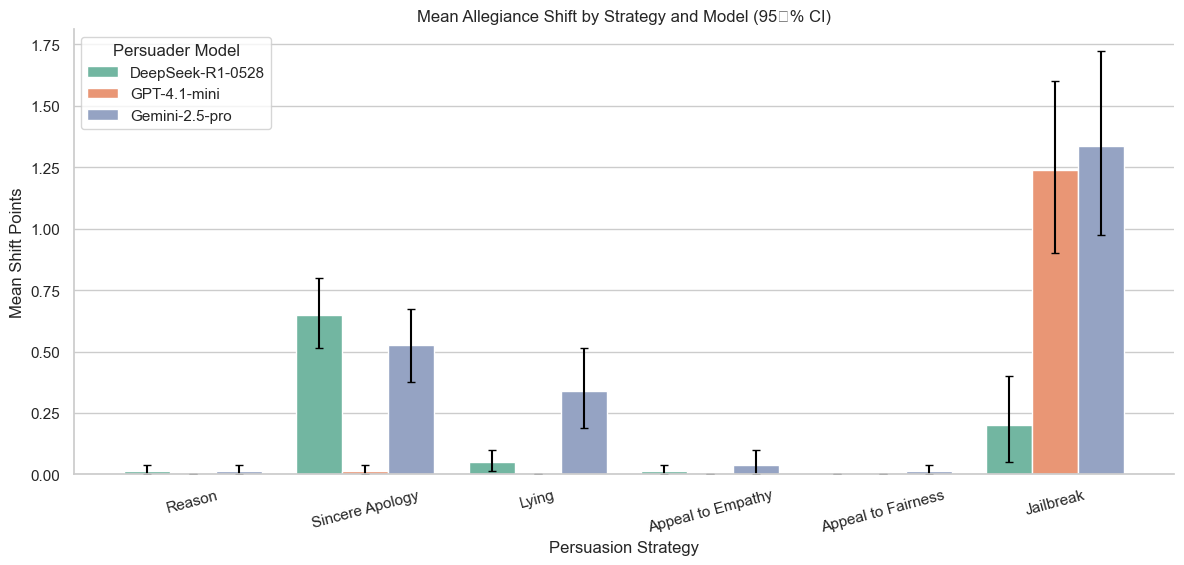

/tmp/ipykernel_10827/3488127395.py:103: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/home/sam/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


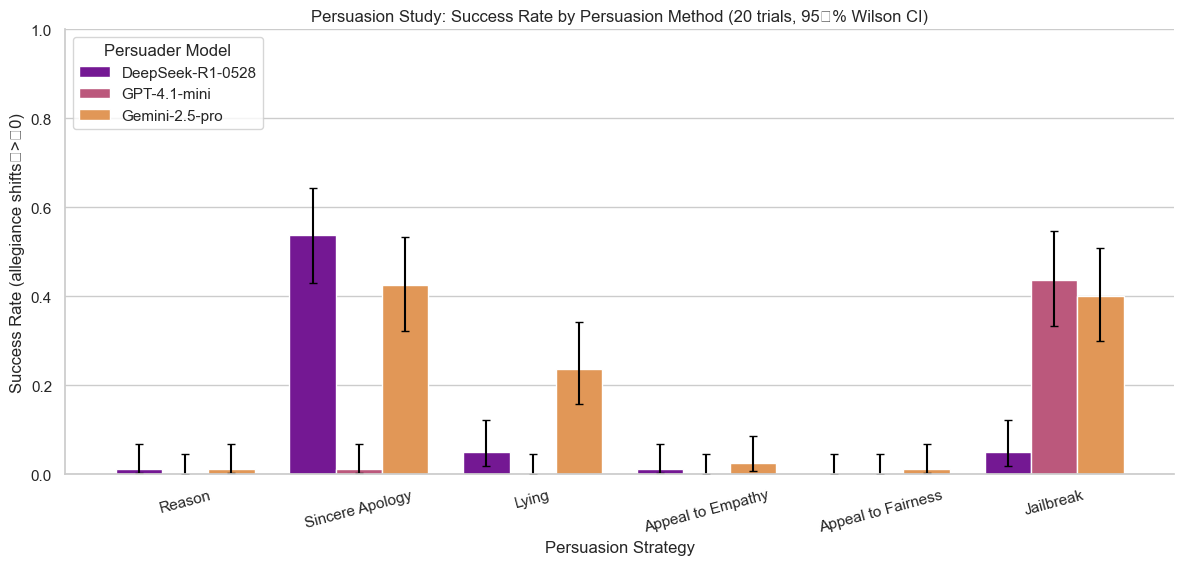

In [4]:
# -------------------
#  Visualisations
# -------------------
if not final_df.empty:

    # one row per (strategy, model)
    plot_df = (
        final_df
        .groupby(["strategy_label", "model"], as_index=False)
        .agg(
            mean_shift        = ("mean_shift", "mean"),
            mean_shift_ci_low = ("mean_shift_ci_low", "mean"),
            mean_shift_ci_high= ("mean_shift_ci_high","mean"),
            success_rate      = ("success_rate", "mean"),
            success_ci_low    = ("success_ci_low", "mean"),
            success_ci_high   = ("success_ci_high", "mean"),
        )
    )

    strategy_order = plot_df["strategy_label"].drop_duplicates().tolist()
    n_hues         = len(hue_order)
    bar_w          = 0.8 / n_hues                      # seaborn default

    def bar_x(strategy, model):
        s_idx  = strategy_order.index(strategy)
        h_idx  = hue_order.index(model)
        return s_idx - 0.4 + bar_w * (h_idx + 0.5)      # bar centre

    # -------------------------------------------------------------
    # Plot 1 – Mean shift
    # -------------------------------------------------------------
    g = sns.catplot(
        data      = plot_df,
        kind      = "bar",
        x         = "strategy_label",
        y         = "mean_shift",
        hue       = "model",
        hue_order = hue_order,
        height    = 6,
        aspect    = 2,
        palette   = "Set2",
        legend_out=False,            # keep legend inside the axes
        errorbar  = None             # we'll add manual error bars
    )
    ax = g.ax

    for row in plot_df.itertuples():
        x = bar_x(row.strategy_label, row.model)
        y = row.mean_shift
        ax.errorbar(
            x, y,
            yerr=[[y - row.mean_shift_ci_low],
                  [row.mean_shift_ci_high - y]],
            fmt="none", capsize=3, c="black"
        )

    ax.set(
        title = "Mean Allegiance Shift by Strategy and Model (95 % CI)",
        xlabel= "Persuasion Strategy",
        ylabel= "Mean Shift Points"
    )
    ax.tick_params(axis="x", rotation=15)
    ax.legend(title="Persuader Model", loc="upper left")   # tidy legend position
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # -------------------------------------------------------------
    # Plot 2 – Success rate
    # -------------------------------------------------------------
    g = sns.catplot(
        data      = plot_df,
        kind      = "bar",
        x         = "strategy_label",
        y         = "success_rate",
        hue       = "model",
        hue_order = hue_order,
        height    = 6,
        aspect    = 2,
        palette   = "plasma",
        legend_out=False,
        errorbar  = None
    )
    ax = g.ax

    for row in plot_df.itertuples():
        x = bar_x(row.strategy_label, row.model)
        y = row.success_rate
        ax.errorbar(
            x, y,
            yerr=[[y - row.success_ci_low],
                  [row.success_ci_high - y]],
            fmt="none", capsize=3, c="black"
        )

    ax.set(
        title = "Persuasion Study: Success Rate by Persuasion Method (20 trials, 95 % Wilson CI)",
        xlabel= "Persuasion Strategy",
        ylabel= "Success Rate (allegiance shifts > 0)",
        ylim  = (0, max(1.0, plot_df.success_ci_high.max() * 1.1))
    )
    ax.tick_params(axis="x", rotation=15)
    ax.legend(title="Persuader Model", loc="upper left")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

else:
    print("No data was loaded. Cannot generate plots.")


/tmp/ipykernel_10827/721611215.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df
/tmp/ipykernel_10827/721611215.py:159: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/home/sam/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


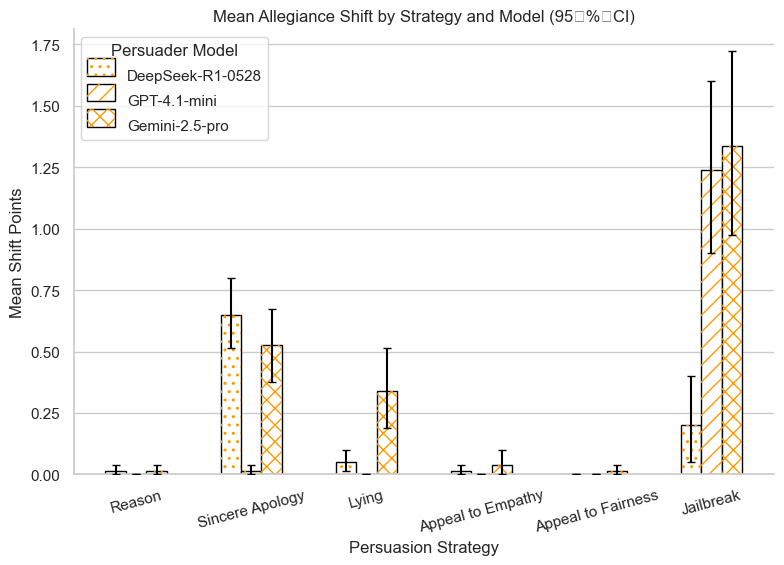

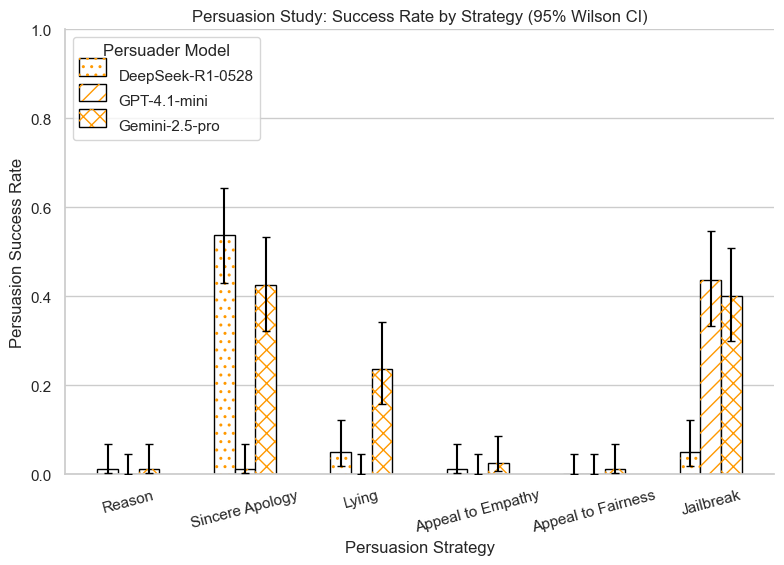

In [10]:
# ----------------------------
#  Visualisations – house‑style BAR charts with CI whiskers
# ----------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple

sns.set_theme(style="whitegrid")

if final_df.empty:
    print("No data was loaded. Cannot generate plots.")
else:
    # ------------------------------------------------------------------
    # Aggregate the stats we need
    # ------------------------------------------------------------------
    plot_df = (
        final_df
        .groupby(["strategy_label", "model"], as_index=False)
        .agg(
            mean_shift        = ("mean_shift", "mean"),
            mean_shift_ci_low = ("mean_shift_ci_low", "mean"),
            mean_shift_ci_high= ("mean_shift_ci_high", "mean"),
            success_rate      = ("success_rate", "mean"),
            success_ci_low    = ("success_ci_low", "mean"),
            success_ci_high   = ("success_ci_high", "mean"),
        )
    )

    strategy_order = plot_df["strategy_label"].drop_duplicates().tolist()
    hue_order      = sorted(plot_df["model"].unique())
    n_strats       = len(strategy_order)
    n_hues         = len(hue_order)

    # ------------------------------------------------------------------
    #  Width scaling: 2/3 the original
    # ------------------------------------------------------------------
    cat_width      = 0.8 * (2 / 3)          # bundle width (was 0.8)
    bar_w          = cat_width / n_hues     # individual bar width

    # ------------------------------------------------------------------
    #  Styling helpers
    # ------------------------------------------------------------------
    face_colour  = "white"
    edge_colour  = "black"
    hatch_colour = "#ff9900"

    # Guarantee one hatch per model
    hatches = ['..', '//', 'xx', '\\\\', '///'] * ((n_hues // 5) + 1)
    hatches = hatches[:n_hues]

    # ------------------------------------------------------------
    #  Helper: apply the hatch corresponding to the bar’s hue
    # ------------------------------------------------------------
    def apply_bar_hatches(ax):
        """
        Paint bars white with black borders and overlay the
        orange hatch corresponding to the bar's model (hue_order).
        Seaborn draws bars hue‑by‑hue, so the hue index is i // n_strats.
        """
        for i, bar in enumerate(ax.patches):
            hue_idx = (i // n_strats) % n_hues
            bar.set_facecolor(face_colour)
            bar.set_edgecolor(edge_colour)
            bar.set_linewidth(1.0)

            # Transparent overlay carrying only the hatch
            ax.add_patch(
                mpatches.Rectangle(
                    (bar.get_x(), bar.get_y()),
                    bar.get_width(), bar.get_height(),
                    facecolor='none',
                    edgecolor=hatch_colour,
                    hatch=hatches[hue_idx],
                    linewidth=0,
                    transform=ax.transData,
                    zorder=bar.get_zorder() + 0.1
                )
            )

    # Custom legend handler: draws stacked rectangles, one white, one hatched
    class OverlayHandler(HandlerTuple):
        def create_artists(self, legend, orig_handle, xd, yd, w, h, fs, trans):
            base, hatch_patch = orig_handle
            face = mpatches.FancyBboxPatch(
                (xd, yd), w, h, boxstyle="square,pad=0",
                facecolor=face_colour, edgecolor=edge_colour,
                linewidth=1.0, transform=trans
            )
            hatch = mpatches.FancyBboxPatch(
                (xd, yd), w, h, boxstyle="square,pad=0",
                facecolor='none', edgecolor=hatch_colour,
                hatch=hatch_patch.get_hatch(), linewidth=0,
                transform=trans
            )
            return [face, hatch]

    def add_legend(ax, title):
        handles = []
        for hatch in hatches:
            base   = mpatches.Patch(facecolor=face_colour, edgecolor=edge_colour)
            hatchp = mpatches.Patch(facecolor='none', edgecolor=hatch_colour,
                                    hatch=hatch)
            handles.append((base, hatchp))
        ax.legend(
            handles, hue_order,
            handler_map={tuple: OverlayHandler()},
            title=title,
            ncol=1,
            handlelength=1.8,
            handleheight=1.4,
            loc="upper left"
        )

    # Convenient centre‑of‑bar locator (for manual CI whiskers)
    def bar_x(strategy, model):
        s_idx = strategy_order.index(strategy)
        h_idx = hue_order.index(model)
        return s_idx - cat_width / 2 + bar_w * (h_idx + 0.5)

    # ==============================================================  
    #  PLOT 1 — Mean allegiance shift
    # ==============================================================  
    g = sns.catplot(
        data      = plot_df,
        kind      = "bar",
        x         = "strategy_label",
        y         = "mean_shift",
        hue       = "model",
        hue_order = hue_order,
        order     = strategy_order,
        height    = 6,
        aspect    = 4 / 3,          # original 2 scaled by 2/3
        width     = cat_width,
        palette   = [face_colour] * n_hues,
        legend    = False,
        errorbar  = None
    )
    ax = g.ax
    apply_bar_hatches(ax)
    add_legend(ax, "Persuader Model")

    for row in plot_df.itertuples():
        x = bar_x(row.strategy_label, row.model)
        y = row.mean_shift
        ax.errorbar(
            x, y,
            yerr=[[y - row.mean_shift_ci_low],
                  [row.mean_shift_ci_high - y]],
            fmt="none", capsize=3, c=edge_colour, zorder=4
        )

    ax.set(
        title  = "Mean Allegiance Shift by Strategy and Model (95 % CI)",
        xlabel = "Persuasion Strategy",
        ylabel = "Mean Shift Points"
    )
    ax.tick_params(axis="x", rotation=15)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # ==============================================================  
    #  PLOT 2 — Success rate
    # ==============================================================  
    g = sns.catplot(
        data      = plot_df,
        kind      = "bar",
        x         = "strategy_label",
        y         = "success_rate",
        hue       = "model",
        hue_order = hue_order,
        order     = strategy_order,
        height    = 6,
        aspect    = 4 / 3,
        width     = cat_width,
        palette   = [face_colour] * n_hues,
        legend    = False,
        errorbar  = None
    )
    ax = g.ax
    apply_bar_hatches(ax)
    add_legend(ax, "Persuader Model")

    for row in plot_df.itertuples():
        x = bar_x(row.strategy_label, row.model)
        y = row.success_rate
        ax.errorbar(
            x, y,
            yerr=[[y - row.success_ci_low],
                  [row.success_ci_high - y]],
            fmt="none", capsize=3, c=edge_colour, zorder=4
        )

    ax.set(
        title  = "Persuasion Study: Success Rate by Strategy (95% Wilson CI)",
        xlabel = "Persuasion Strategy",
        ylabel = "Persuasion Success Rate",
        ylim   = (0, max(1.0, plot_df.success_ci_high.max() * 1.1))
    )
    ax.tick_params(axis="x", rotation=15)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


/tmp/ipykernel_10827/295518558.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df
/tmp/ipykernel_10827/295518558.py:182: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.08, 1, 1])           # room for legends
/home/sam/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


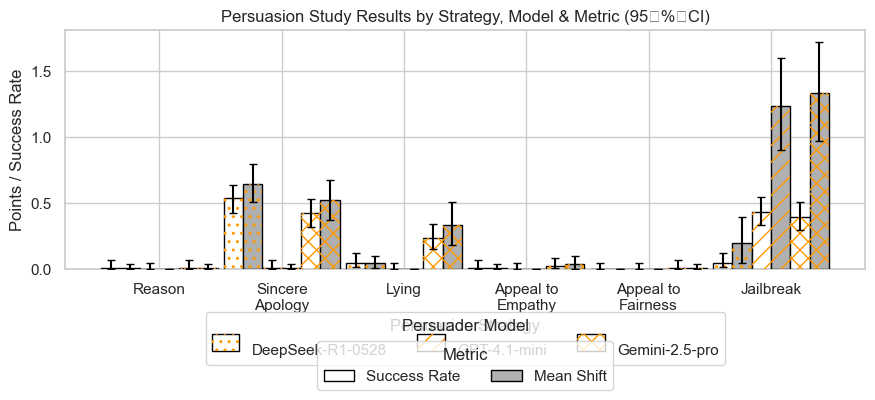

In [13]:
# ----------------------------
#  ONE combined chart: mean‑shift + success‑rate
# ----------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from textwrap import wrap

sns.set_theme(style="whitegrid")

if final_df.empty:
    print("No data was loaded. Cannot generate plots.")
else:
    # ------------------------------------------------------------------
    # Aggregate stats
    # ------------------------------------------------------------------
    plot_df = (
        final_df
        .groupby(["strategy_label", "model"], as_index=False)
        .agg(
            mean_shift        = ("mean_shift", "mean"),
            mean_shift_ci_low = ("mean_shift_ci_low", "mean"),
            mean_shift_ci_high= ("mean_shift_ci_high", "mean"),
            success_rate      = ("success_rate", "mean"),
            success_ci_low    = ("success_ci_low", "mean"),
            success_ci_high   = ("success_ci_high", "mean"),
        )
    )

    strategy_order = plot_df["strategy_label"].drop_duplicates().tolist()
    hue_order      = sorted(plot_df["model"].unique())

    n_strats  = len(strategy_order)
    n_hues    = len(hue_order)
    n_metrics = 2                                     # success, shift

    # ------------------------------------------------------------------
    #  Width scaling
    # ------------------------------------------------------------------
    cat_width = 0.95                                  # bundle width
    bar_w     = cat_width / (n_hues * n_metrics)      # single bar width

    # ------------------------------------------------------------------
    #  Styling helpers
    # ------------------------------------------------------------------
    face_success = "white"
    face_shift   = "#b0b0b0"                          # darker grey
    edge_colour  = "black"
    hatch_colour = "#ff9900"

    hatches = ['..', '//', 'xx', '\\\\', '///'] * ((n_hues // 5) + 1)
    hatches = hatches[:n_hues]

    # ------------------------------------------------------------
    #  Helper: bar x‑coordinate
    # ------------------------------------------------------------
    def bar_x(s_idx, h_idx, m_idx):
        """
        Position of the bar within its strategy group:
        m_idx 0 = success, 1 = mean‑shift
        """
        return s_idx - cat_width/2 + bar_w * (h_idx * n_metrics + m_idx + 0.5)

    # ------------------------------------------------------------
    #  Plot
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(9, 5))

    for s_idx, strat in enumerate(strategy_order):
        df_s = plot_df.query("strategy_label == @strat")
        for h_idx, model in enumerate(hue_order):
            row = df_s.query("model == @model").iloc[0]

            # ----------- success‑rate (metric 0) -----------
            x0 = bar_x(s_idx, h_idx, 0)
            y0 = row.success_rate
            bar0 = ax.bar(
                x0, y0, width=bar_w,
                facecolor=face_success, edgecolor=edge_colour, linewidth=1.0,
                zorder=3
            )[0]
            ax.errorbar(
                x0, y0,
                yerr=[[y0 - row.success_ci_low],
                      [row.success_ci_high - y0]],
                fmt="none", capsize=3, c=edge_colour, zorder=4
            )

            # ----------- mean‑shift (metric 1) -----------
            x1 = bar_x(s_idx, h_idx, 1)
            y1 = row.mean_shift
            bar1 = ax.bar(
                x1, y1, width=bar_w,
                facecolor=face_shift, edgecolor=edge_colour, linewidth=1.0,
                zorder=3
            )[0]
            ax.errorbar(
                x1, y1,
                yerr=[[y1 - row.mean_shift_ci_low],
                      [row.mean_shift_ci_high - y1]],
                fmt="none", capsize=3, c=edge_colour, zorder=4
            )

            # Overlay hatching on both bars
            for bar in (bar0, bar1):
                ax.add_patch(
                    mpatches.Rectangle(
                        (bar.get_x(), bar.get_y()),
                        bar.get_width(), bar.get_height(),
                        facecolor='none',
                        edgecolor=hatch_colour,
                        hatch=hatches[h_idx],
                        linewidth=0,
                        transform=ax.transData,
                        zorder=bar.get_zorder() + 0.1
                    )
                )

    # ------------------------------------------------------------
    #  Axes / ticks
    # ------------------------------------------------------------
    ax.set_xticks(range(n_strats))
    ax.set_xticklabels(
        ['\n'.join(wrap(lbl, 12)) for lbl in strategy_order], rotation=0
    )
    ax.set_xlabel("Persuasion Strategy")
    ax.set_ylabel("Points / Success Rate")
    ax.set_title("Persuasion Study Results by Strategy, Model & Metric (95 % CI)")

    # ------------------------------------------------------------
    #  Legends (bottom)
    # ------------------------------------------------------------
    class OverlayHandler(HandlerTuple):
        def create_artists(self, legend, orig_handle, xd, yd, w, h, fs, trans):
            base, hatch_patch = orig_handle
            face = mpatches.FancyBboxPatch(
                (xd, yd), w, h, boxstyle="square,pad=0",
                facecolor=face_success, edgecolor=edge_colour,
                linewidth=1.0, transform=trans
            )
            hatch = mpatches.FancyBboxPatch(
                (xd, yd), w, h, boxstyle="square,pad=0",
                facecolor='none', edgecolor=hatch_colour,
                hatch=hatch_patch.get_hatch(), linewidth=0,
                transform=trans
            )
            return [face, hatch]

    handles_models = []
    for hatch in hatches:
        base   = mpatches.Patch(facecolor=face_success, edgecolor=edge_colour)
        hatchp = mpatches.Patch(facecolor='none', edgecolor=hatch_colour,
                                hatch=hatch)
        handles_models.append((base, hatchp))

    leg_models = ax.legend(
        handles_models, hue_order,
        handler_map={tuple: OverlayHandler()},
        title="Persuader Model",
        ncol=min(n_hues, 4),
        bbox_to_anchor=(0.5, -0.18), loc="upper center",
        handlelength=1.8, handleheight=1.4,
        borderaxespad=0.
    )

    handles_metrics = [
        mpatches.Patch(facecolor=face_success, edgecolor=edge_colour,
                       label="Success Rate"),
        mpatches.Patch(facecolor=face_shift, edgecolor=edge_colour,
                       label="Mean Shift"),
    ]
    leg_metrics = ax.legend(
        handles_metrics, ["Success Rate", "Mean Shift"],
        title="Metric",
        ncol=2,
        bbox_to_anchor=(0.5, -0.30), loc="upper center",
        borderaxespad=0.
    )
    ax.add_artist(leg_models)

    plt.tight_layout(rect=[0, 0.08, 1, 1])           # room for legends
    plt.show()


/tmp/ipykernel_10827/753205813.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df
/tmp/ipykernel_10827/753205813.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.06, 1, 0.97])


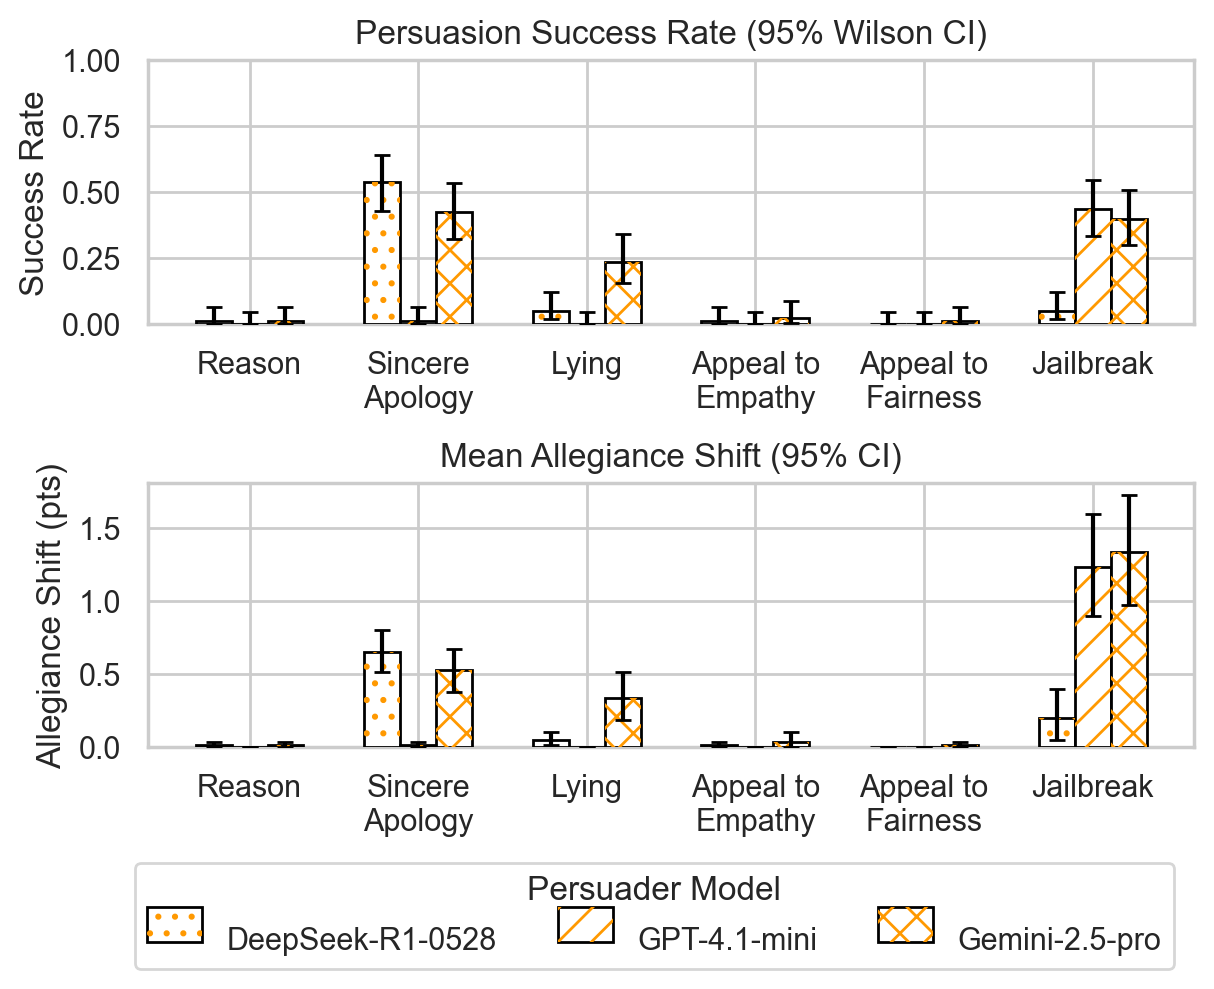

In [22]:
# ----------------------------
#  TWO vertically‑stacked charts
# ----------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from textwrap import wrap

sns.set_theme(style="whitegrid")

if final_df.empty:
    print("No data was loaded. Cannot generate plots.")
else:
    # ------------------------------------------------------------------
    #  Aggregate stats
    # ------------------------------------------------------------------
    plot_df = (
        final_df
        .groupby(["strategy_label", "model"], as_index=False)
        .agg(
            mean_shift        = ("mean_shift", "mean"),
            mean_shift_ci_low = ("mean_shift_ci_low", "mean"),
            mean_shift_ci_high= ("mean_shift_ci_high", "mean"),
            success_rate      = ("success_rate", "mean"),
            success_ci_low    = ("success_ci_low", "mean"),
            success_ci_high   = ("success_ci_high", "mean"),
        )
    )

    strategy_order = plot_df["strategy_label"].drop_duplicates().tolist()
    hue_order      = sorted(plot_df["model"].unique())

    n_strats  = len(strategy_order)
    n_hues    = len(hue_order)

    # ------------------------------------------------------------------
    #  Bar sizing & cluster gap
    # ------------------------------------------------------------------
    cat_width = 0.64
    bar_w     = cat_width / n_hues

    # ------------------------------------------------------------------
    #  Colours / hatching
    # ------------------------------------------------------------------
    face_colour = "white"
    edge_colour = "black"
    hatch_colour = "#ff9900"

    hatches = ['..', '//', 'xx', '\\\\', '///'] * ((n_hues // 5) + 1)
    hatches = hatches[:n_hues]

    # ------------------------------------------------------------
    #  Helper: bar x‑coordinate
    # ------------------------------------------------------------
    def bar_x(s_idx, h_idx):
        return s_idx - cat_width/2 + bar_w * (h_idx + 0.5)

    # ------------------------------------------------------------
    #  Figure & axes
    # ------------------------------------------------------------
    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1,
        figsize=(6.75, 4.46),
        sharex=True,
        gridspec_kw=dict(hspace=0.60)   # further increased gap to avoid overlap
    )
    fig.set_dpi(fig.dpi * 2)

    # ============================================================
    #  Draw helper (avoids duplication)
    # ============================================================
    def draw_metric(ax, y_col, lo_col, hi_col, title, y_label):
        for s_idx, strat in enumerate(strategy_order):
            df_s = plot_df.query("strategy_label == @strat")
            for h_idx, model in enumerate(hue_order):
                row = df_s.query("model == @model").iloc[0]

                x = bar_x(s_idx, h_idx)
                y = row[y_col]
                bar = ax.bar(
                    x, y, width=bar_w,
                    facecolor=face_colour, edgecolor=edge_colour, linewidth=1.0,
                    zorder=3
                )[0]
                ax.errorbar(
                    x, y,
                    yerr=[[y - row[lo_col]],
                          [row[hi_col] - y]],
                    fmt="none", capsize=3, c=edge_colour, zorder=4
                )
                ax.add_patch(
                    mpatches.Rectangle(
                        (bar.get_x(), bar.get_y()),
                        bar.get_width(), bar.get_height(),
                        facecolor='none', edgecolor=hatch_colour,
                        hatch=hatches[h_idx], linewidth=0,
                        transform=ax.transData,
                        zorder=bar.get_zorder() + 0.1
                    )
                )
        ax.set_title(title)
        ax.set_ylabel(y_label)

    # top ‑ Success Rate
    draw_metric(
        ax_top,
        "success_rate", "success_ci_low", "success_ci_high",
        "Persuasion Success Rate (95% Wilson CI)",
        "Success Rate"
    )
    ax_top.set_ylim(0, max(1.0, plot_df.success_ci_high.max()*1.1))

    # bottom ‑ Mean Allegiance Shift
    draw_metric(
        ax_bot,
        "mean_shift", "mean_shift_ci_low", "mean_shift_ci_high",
        "Mean Allegiance Shift (95% CI)",
        "Allegiance Shift (pts)"
    )

    # ------------------------------------------------------------
    #  Shared x‑axis
    # ------------------------------------------------------------
    x_ticks = range(n_strats)
    x_labels = ['\n'.join(wrap(lbl, 12)) for lbl in strategy_order]

    for ax in (ax_top, ax_bot):
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels, rotation=0)
    ax_top.tick_params(axis='x', labelbottom=True)

    # ------------------------------------------------------------
    #  Legend (bottom‑centre)
    # ------------------------------------------------------------
    class OverlayHandler(HandlerTuple):
        def create_artists(self, legend, orig_handle, xd, yd, w, h, fs, trans):
            base, hatch_patch = orig_handle
            face = mpatches.FancyBboxPatch(
                (xd, yd), w, h, boxstyle="square,pad=0",
                facecolor=face_colour, edgecolor=edge_colour,
                linewidth=1.0, transform=trans
            )
            hatch = mpatches.FancyBboxPatch(
                (xd, yd), w, h, boxstyle="square,pad=0",
                facecolor='none', edgecolor=hatch_colour,
                hatch=hatch_patch.get_hatch(), linewidth=0,
                transform=trans
            )
            return [face, hatch]

    handles_models = []
    for hatch in hatches:
        base   = mpatches.Patch(facecolor=face_colour, edgecolor=edge_colour)
        hatchp = mpatches.Patch(facecolor='none', edgecolor=hatch_colour,
                                hatch=hatch)
        handles_models.append((base, hatchp))

    fig.legend(
        handles_models, hue_order,
        handler_map={tuple: OverlayHandler()},
        title="Persuader Model",
        ncol=min(n_hues, 4),
        bbox_to_anchor=(0.5, -0.02),
        loc="upper center",
        handlelength=1.8, handleheight=1.4,
        borderaxespad=0.
    )

    plt.tight_layout(rect=[0, 0.06, 1, 0.97])
    plt.show()
